In [3]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt 

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
     shuffle=True,
     image_size=(IMAGE_SIZE,IMAGE_SIZE),
      batch_size=(BATCH_SIZE)
)

Found 2152 files belonging to 3 classes.


In [9]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [11]:
len(dataset)

68

In [13]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 2 2 0 1 0 0 0 1 0 1 1 1 0 1 1 0 0 1 0 1 0 1 0 2 0 2 1 1 0]


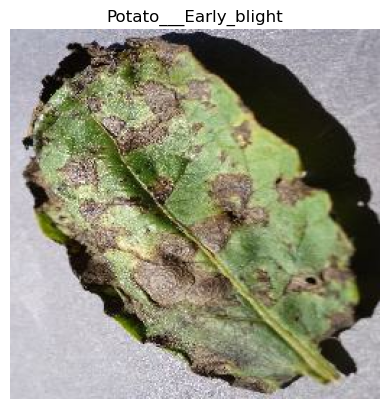

In [15]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

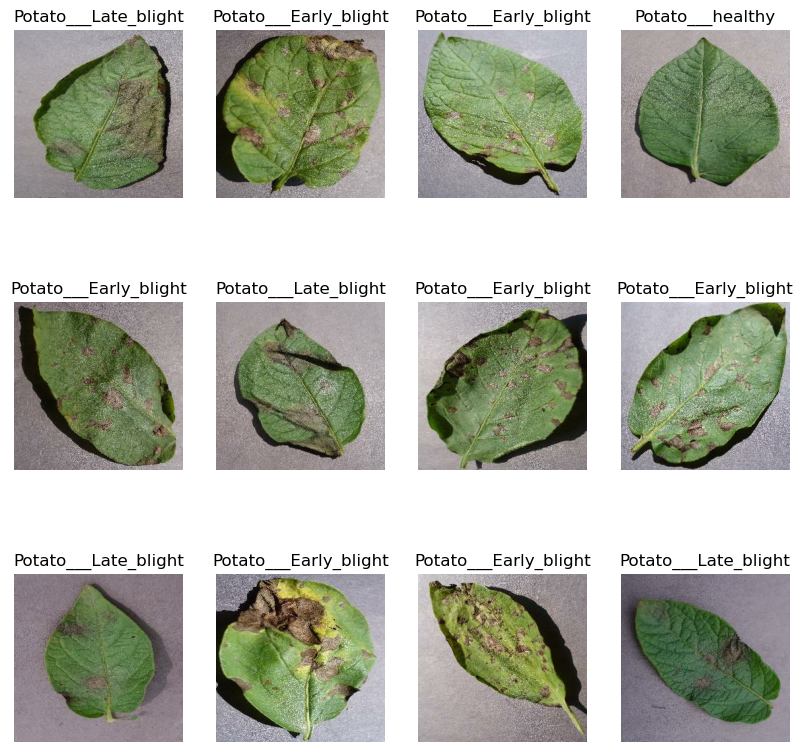

In [17]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [19]:
#80% ==> training
#20% ==> 10% validation, 10 % test

In [21]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [23]:
train_ds = dataset.take(54)
len(train_ds)

54

In [25]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [27]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [29]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [31]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [33]:
def get_dataset_partitions_tf(ds, train_spilt= 0.8, val_spilt= 0.1, test_spilt = 0.1, shuffle= True, shuffle_size = 10000):
    assert (train_spilt + test_spilt + val_spilt) == 1
    ds_size = len(ds)
    if shuffle:
        ds= ds.shuffle(shuffle_size, seed =12)
        
    train_size = int(train_spilt * ds_size)
    val_size = int(val_spilt * ds_size )
    
    train_ds = ds.take(train_size)
    val_ds= ds.skip(train_size).take(val_size)
    test_ds= ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [35]:
train_ds,  val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [37]:
len(train_ds)

54

In [39]:
len(val_ds)

6

In [41]:
len (test_ds)

8

In [43]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds= test_ds.cache().prefetch(buffer_size= tf.data.AUTOTUNE)

In [45]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])


In [47]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [49]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
    


]) 
model.build(input_shape= input_shape)


D:\ANaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


model.summary()

In [52]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [56]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 470ms/step - accuracy: 0.4965 - loss: 0.9059 - val_accuracy: 0.6042 - val_loss: 0.8337
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 465ms/step - accuracy: 0.7060 - loss: 0.6579 - val_accuracy: 0.8021 - val_loss: 0.4474
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 505ms/step - accuracy: 0.8356 - loss: 0.4119 - val_accuracy: 0.9062 - val_loss: 0.2969
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 511ms/step - accuracy: 0.8808 - loss: 0.2987 - val_accuracy: 0.8958 - val_loss: 0.2534
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 448ms/step - accuracy: 0.8981 - loss: 0.2701 - val_accuracy: 0.9323 - val_loss: 0.1654
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 430ms/step - accuracy: 0.9317 - loss: 0.1738 - val_accuracy: 0.9323 - val_loss: 0.1396
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 435ms/step - accuracy: 0.9433 - loss: 0.1487 - val_accuracy: 0.9375 - val_loss: 0.1255
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 441ms/step - accuracy: 0.9462 - loss: 0.1296 - val_accu

In [58]:
scores = model.evaluate(test_ds)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9961 - loss: 0.0555


In [59]:
scores


[0.055455297231674194, 0.99609375]

In [62]:
history


In [64]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [66]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [68]:
type(history.history['loss'])

list

In [70]:
len(history.history['loss'])

50

In [72]:
history.history['loss'][:5]

[0.9059368371963501,
 0.6578918099403381,
 0.41194668412208557,
 0.29871809482574463,
 0.27008065581321716]

In [74]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
loss=history.history['loss']
val_loss= history.history['val_loss']

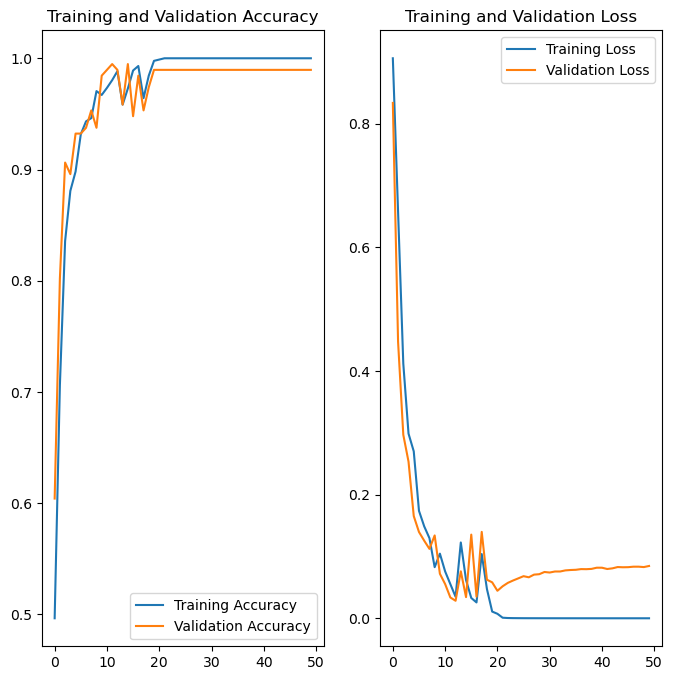

In [76]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
predicted label: Potato___Early_blight


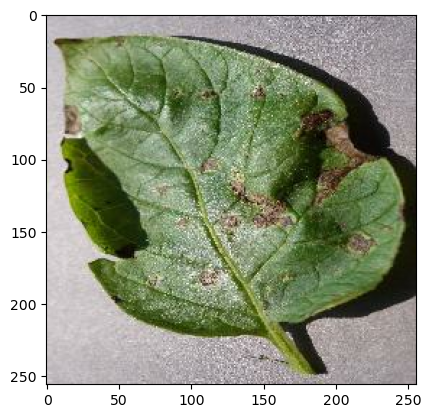

In [78]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [80]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


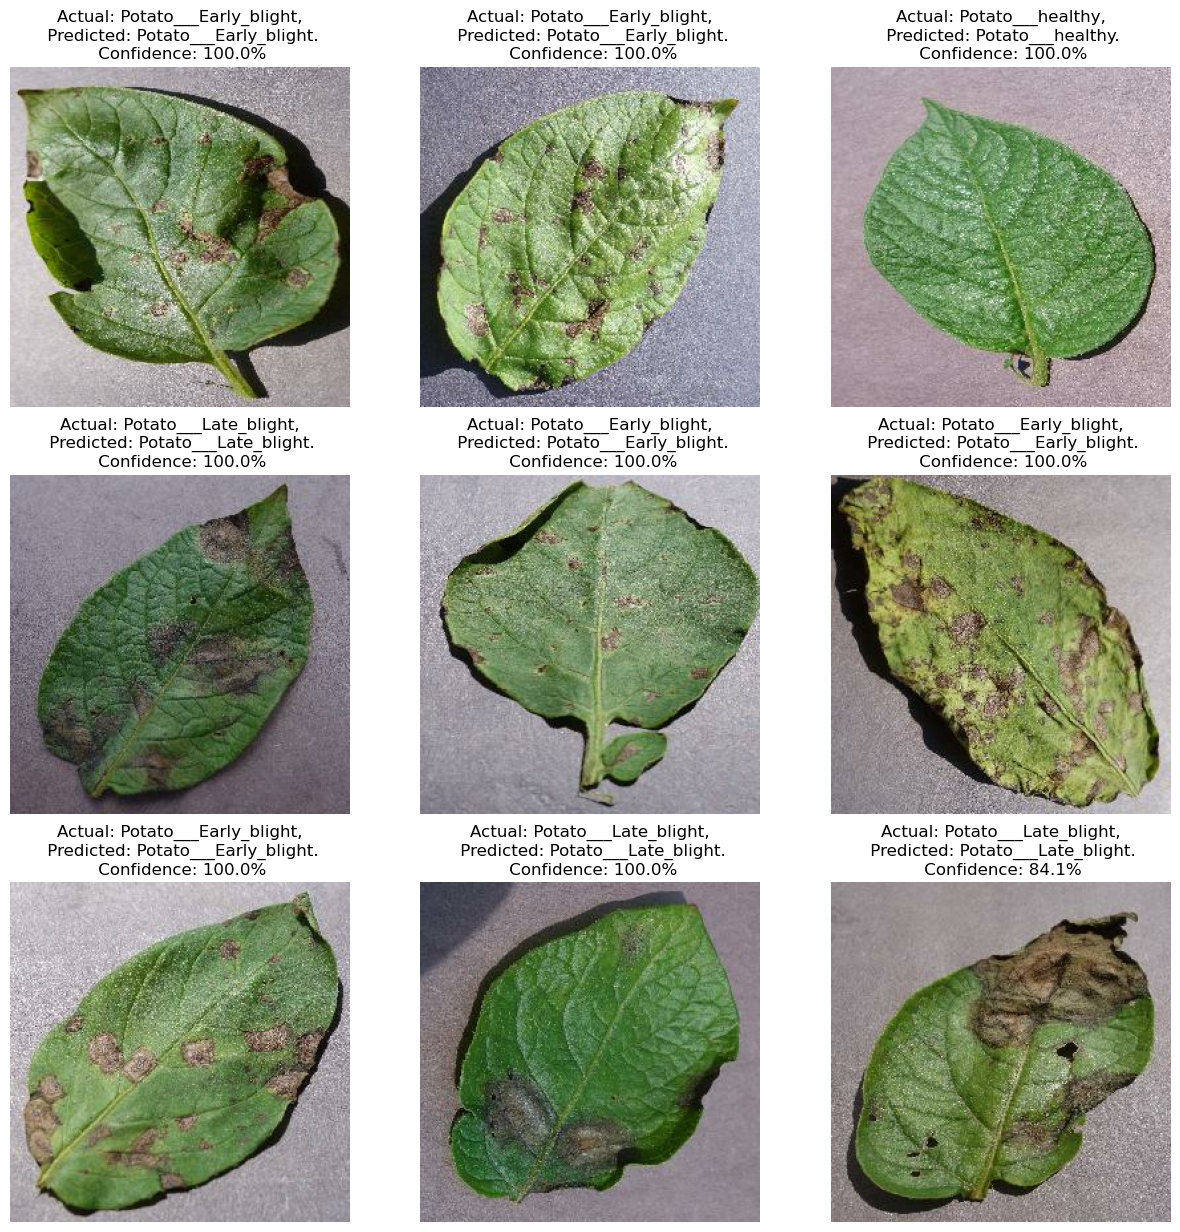

In [82]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


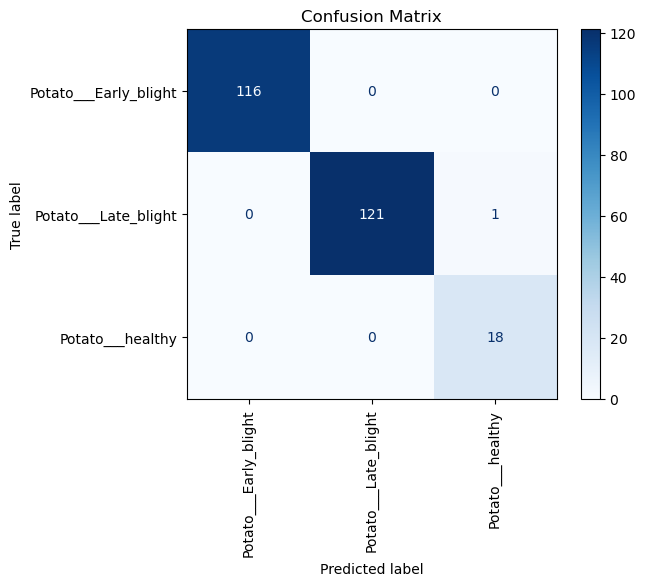

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true = []
y_pred = []

for images_batch, labels_batch in test_ds:
    preds = model.predict(images_batch)               # predict batch
    preds_classes = np.argmax(preds, axis=1)          # get class index
    y_pred.extend(preds_classes)                      # append to predictions list
    y_true.extend(labels_batch.numpy())               # append true labels
cm = confusion_matrix(y_true, y_pred)  
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()


In [96]:
# Save the model
model.save("models/potato_model.keras")

# Load the model
from tensorflow import keras
model = keras.models.load_model("models/potato_model.keras")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Actual label: Potato___Early_blight
Predicted label: Potato___Early_blight
Confidence: 99.99991655349731 %


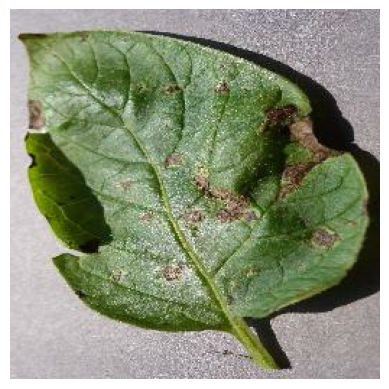

In [106]:
# 2️⃣ Take one batch from your test dataset
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy()  # Already normalized if you used Rescaling
    first_label = labels_batch[0].numpy()
    break  # only need the first batch

# 3️⃣ Predict
preds = model.predict(np.expand_dims(first_image, axis=0))  # add batch dimension
predicted_class_index = np.argmax(preds[0])

# 4️⃣ Show image and results
plt.imshow(first_image.astype(np.uint8))
plt.axis('off')
print("Actual label:", class_names[first_label])
print("Predicted label:", class_names[predicted_class_index])
print("Confidence:", np.max(preds[0])*100, "%")